# Введение в анализ данных (первый семестр)
## Домашнее задание №2 - Ускорение k-means


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics.pairwise import distance_metrics, pairwise_distances

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

from line_profiler import LineProfiler

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

In [2]:
def profile_print(func_to_call, *args):
    profiler = LineProfiler()
    profiler.add_function(func_to_call)
    profiler.runcall(func_to_call, *args)
    profiler.print_stats()

# Имплементация K-means

### Имплементация в виде функции

In [3]:
def k_means(X, n_clusters=2, metric='euclidean', max_iter=1000, random_state=None):
    # Инициализация генератора случайных чисел
    np.random.seed(random_state)

    # Массив с метками кластеров для каждого объекта из X
    labels = np.zeros(X.shape[0], dtype=int)
    labels.fill(-1)

    # Массив с центроидами кластеров
    centroids = np.random.random((n_clusters, X.shape[1]))
    min_values = np.min(X, axis=0) 
    values_ranges = np.max(X, axis=0) - min_values
    centroids = min_values + (values_ranges * centroids)

    # init tmp (old) centroids and labels
    old_centroids = centroids.copy()
    old_labels = labels.copy()

    # loop over iterations and while centroids not found
    n_iters = 0
    for n_iters in xrange(max_iter):
        # store prev iteration params
        np.copyto(old_centroids, centroids)
        np.copyto(old_labels, labels)

        # for each sample, give it a label of nearest centroid
        labels = distance_metrics()[metric](X, centroids).argmin(axis=1)

        # for each cluster, compute average, it will be a new centroid   
        for c in xrange(centroids.shape[0]):
            centroids[c] = np.average(X[(labels == c)], axis=0)

        # if no points assigned to centroid, do not change centroid coords
        nan_rows = np.isnan(centroids).any(axis=1)
        centroids[nan_rows] = old_centroids[nan_rows]

        # check if clusters change, if not, stop
        if np.array_equal(labels, old_labels):
            break
    
    return labels, centroids, n_iters

### Имплементация в виде класса

In [32]:
class Kmeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, n_clusters=2, metric='euclidean', max_iter=1000, random_state=None):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максимальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.n_iters = None
        self.X = None
        self.labels = None
        self.centroids = None
        self._check_params()
        
    def _check_params(self):
        if self.max_iter < 0:
            raise ValueError("number of iterations (set %d) must be non-negative" % (self.max_iter))
        if self.n_clusters < 1:
            raise ValueError("number of clusters (set %d) must be positive" % (self.n_clusters))
        if self.metric not in distance_metrics().keys():
            raise ValueError("specified metric (%s) is not supported. List of supported metrics:\n%s" % 
                             (self.metric, ', '.join(distance_metrics().keys())))
        
    def _check_and_prepare_X(self, X):
        if not isinstance(X, np.ndarray) and not isinstance(X, pd.DataFrame):
            raise ValueError("X must have numpy.ndarray or pandas.DataFrame type, but given X has type " +  str(type(X)))
        if self.n_clusters > X.shape[0]:
            raise ValueError("number of clusters (set %d) must be not greater than number of samples (set %d)" % 
                             (self.n_clusters, X.shape[0]))
        if isinstance(X, pd.DataFrame):
            self.X = X.as_matrix()
        else:
            self.X = X
            
    def _check_if_fitted(self):
        if self.centroids is None:
            raise RuntimeError("clustering object is not fitted yet, so centroids are not set")
                             
    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        :X - матрица наблюдений (numpy.ndarray или pandas.DataFrame)
        :y - вектор меток (данный параметр не используется в обучении без учителя)
        """
        
        # Проверяем входной датасет и подготавливаем его к обработке
        self._check_and_prepare_X(X)
        
        self.labels, self.centroids, self.n_iters = k_means(self.X, self.n_clusters, self.metric, 
                                                            self.max_iter, self.random_state)
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        # Проверяем входной датасет  подготавливаем его к обработке
        self._check_and_prepare_X(X)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.zeros(self.X.shape[0], dtype=int)
        self.labels.fill(-1)
        
        self._check_if_fitted()
        self.labels = distance_metrics()[self.metric](X, self.centroids).argmin(axis=1)
        
        return self.labels

### Проверка корректности метода

Number of iterations: 3


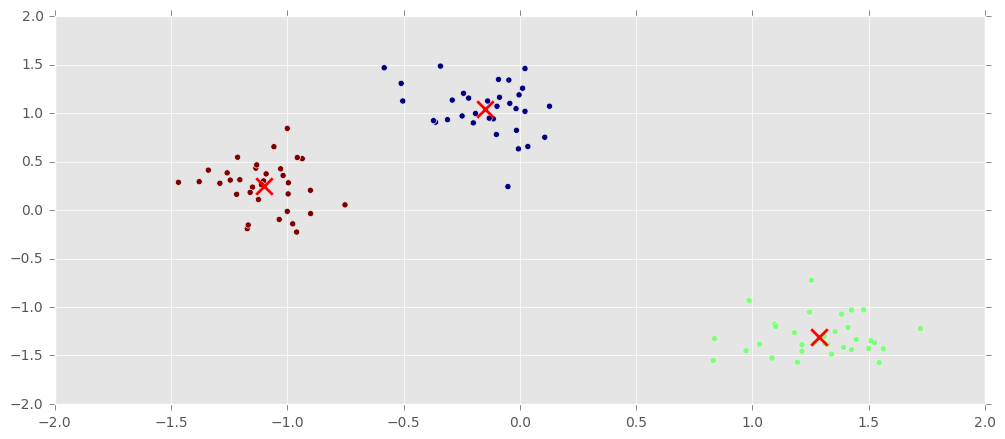

In [33]:
def check_kmeans(func, *args):
    
    X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
               center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

    sc = StandardScaler()
    X = sc.fit_transform(X)
    km = Kmeans(max_iter=100, n_clusters=3, random_state=42)
    km.fit(X)
    lbls, _, ntrs = func(*args)
    labels = km.predict(X)
    print "Number of iterations:", km.n_iters

    plt.scatter(X[:,0], X[:, 1], c=labels)
    plt.scatter(km.centroids[:,0], km.centroids[:,1], c='red', marker='x', s=140, linewidths=2)
    
    return

# Применение K-means на реальных данных

In [22]:
df_sns = pd.read_csv('snsdata.csv', sep=',')

# delete all features except 36 keywords
df_sns_restricted = df_sns[df_sns.columns[4:]]

# normalize
for column in df_sns_restricted.columns:
    df_sns_restricted.loc[:,column] = (df_sns_restricted[column] - df_sns_restricted[column].mean())/\
    df_sns_restricted[column].var()
df_sns_restricted.head()

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,-0.412835,-0.507107,-0.264788,-0.294609,-0.349509,-0.502846,-0.403092,-0.385504,-0.326787,-0.630717,...,-0.026224,-0.531663,-0.672712,-0.664761,-0.580983,-0.654713,-0.472027,-0.598737,-0.552206,-0.506205
1,-0.412835,1.502830,-0.264788,-0.294609,-0.349509,-0.502846,-0.403092,-0.385504,-0.326787,-0.630717,...,-0.026224,1.534117,-0.672712,-0.664761,-0.580983,-0.654713,-0.472027,-0.598737,-0.552206,-0.506205
2,-0.412835,1.502830,-0.264788,-0.294609,-0.349509,-0.502846,-0.403092,-0.385504,-0.326787,-0.630717,...,-0.026224,-0.531663,-0.672712,-0.664761,-0.580983,-0.654713,-0.472027,4.642616,-0.552206,-0.506205
3,-0.412835,-0.507107,-0.264788,-0.294609,-0.349509,-0.502846,-0.403092,-0.385504,-0.326787,-0.630717,...,-0.026224,-0.531663,-0.672712,-0.664761,-0.580983,-0.654713,-0.472027,-0.598737,-0.552206,-0.506205
4,-0.412835,-0.507107,-0.264788,-0.294609,-0.349509,-0.502846,-0.403092,-0.385504,-0.326787,-0.630717,...,-0.026224,-0.531663,3.138686,-0.664761,-0.580983,-0.654713,-0.472027,-0.598737,5.725238,7.870048


In [39]:
# found random states and non-empty clusters for them
# [0 1 2 3 5 6 7 8] 201949
# [0 1 2 3 4 5 7 8] 1515
X = df_sns_restricted.as_matrix()
km = Kmeans(n_clusters=9, random_state=1515)
%timeit -n 1 km.fit(X)
%timeit -n 1 k_means(X, n_clusters=9, random_state=1515)
lbls, cntrds, ntrs = k_means(X, n_clusters=9, random_state=1515)
print "Class:", np.unique(km.labels), km.n_iters
print "Func: ", np.unique(lbls), ntrs

1 loop, best of 3: 465 ms per loop
1 loop, best of 3: 408 ms per loop
Class: [0 1 2 3 4 5 7 8] 21
Func:  [0 1 2 3 4 5 7 8] 21


Из замеров времени видно, что разница между функцией и классом по времени незначительная в пользу функции (т.к. нет никаких проверок входных аргументов, в отличие от класса). Поэтому, в дальнейшем будем модифицировать функцию, т.к. это более удобно.

In [25]:
profile_print(k_means, X, 9, 'euclidean', 1000, 1515)

Timer unit: 5.70181e-07 s

Total time: 0.488389 s
File: <ipython-input-3-22bc051143a0>
Function: k_means at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def k_means(X, n_clusters=2, metric='euclidean', max_iter=1000, random_state=None):
     2                                               # Инициализация генератора случайных чисел
     3         1           33     33.0      0.0      np.random.seed(random_state)
     4                                           
     5                                               # Массив с метками кластеров для каждого объекта из X
     6         1           62     62.0      0.0      labels = np.zeros(X.shape[0], dtype=int)
     7         1           26     26.0      0.0      labels.fill(-1)
     8                                           
     9                                               # Массив с центроидами кластеров
    10         1           44     44.0      0.0      c